In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from astropy.io import fits
import camb
import quaternionic
import spherical
import scipy

In [2]:
h = 6.62660755 * 10**(-27) #ergs
k = 1.380658 * 10**(-16) #erg/K
c = 2.99792458 * 10**10 #cm/s
T_c = 2.725 #K

In [3]:
nside_ = 1024
lmax_ = 3*nside_-1
lmaxp = 2*nside_

In [4]:
nside=4
npix = 12*nside**2
lmax = 2*nside

# CMB map, cl

In [5]:
theta_pix = np.sqrt(4*np.pi/npix)
rad = 2.5*theta_pix #rad
rad

0.6395791924665553

In [6]:
rs = [0.001, 0.01, 0.1, 1.0]
#rs = np.logspace(-3,0,50)
i_r = 0
rs[i_r]

0.001

In [7]:
#Set up a new set of parameters for CAMB
pars = camb.CAMBparams()
#rs = [0.001, 0.002, 0.003, 0.005, 0.01, 0.0005, 0.0001, 0.00001, 0.000001, 0.0]
pars.set_cosmology(H0=70.5, ombh2=0.02267, omch2=0.1131, mnu=0.06, omk=0, tau=0.09)
pars.set_for_lmax(2048, lens_potential_accuracy=1)
pars.WantTensors = True
pars.max_l_tensor = 2048
pars.max_eta_k_tensor = 4096
results = camb.get_transfer_functions(pars)

In [8]:
def CMBMAP(nside, rs):
    c_cls = []
    c_maps = []
    c_maps_ = np.zeros((len(rs), 2*npix))
    for i,r in enumerate(rs):
        inflation_params = camb.initialpower.InitialPowerLaw()
        inflation_params.set_params(As=2.3e-9, ns=1., r=r)
        results.power_spectra_from_transfer(inflation_params) #warning OK here, not changing scalars
        c_cl = results.get_total_cls(2048, CMB_unit='muK')
        c_cls.append(c_cl)
        np.random.seed(0)
        ell = np.arange(c_cl.shape[0])
        ell[0]=1
        c_map1 = hp.synfast(c_cl.T/ell/(ell+1)*2*np.pi, nside=nside, new=True)#, fwhm=rad)#, pixwin=True)
        c_maps.append(c_map1)
        print(r)
    return c_maps, c_cls

In [9]:
c_maps, c_cls = CMBMAP(nside, rs)

0.001
0.01
0.1
1.0


/home/tama/anaconda3/lib/python3.9/site-packages/healpy/sphtfunc.py:822: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  warnings.warn(
/home/tama/anaconda3/lib/python3.9/site-packages/healpy/sphtfunc.py:827: UserWarning: -> fwhm is 0.000000 arcmin
  warnings.warn(


c_map_sm = hp.sphtfunc.smoothing(c_maps[i_r], fwhm=rad)

plt.figure(figsize=(15,6))
hp.mollview(c_map_sm[0], norm='hist', sub=(1,5,1), title='I_cmb', unit="uK_cmb")
hp.mollview(c_map_sm[1], norm='hist', sub=(1,5,2), title='Q_cmb', unit="uK_cmb")
hp.mollview(c_map_sm[2], norm='hist', sub=(1,5,3), title='U_cmb', unit="uK_cmb")

/home/tama/anaconda3/lib/python3.9/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_over(newcm(1.0))
/home/tama/anaconda3/lib/python3.9/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_under(bgcolor)
/home/tama/anaconda3/lib/python3.9/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has b

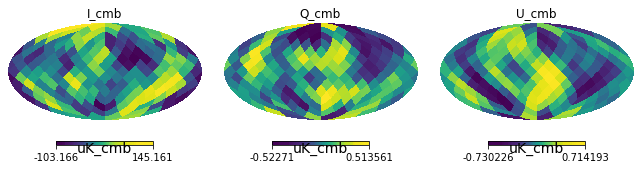

In [10]:
plt.figure(figsize=(15,6))
hp.mollview(c_maps[i_r][0], norm='hist', sub=(1,5,1), title='I_cmb', unit="uK_cmb")
hp.mollview(c_maps[i_r][1], norm='hist', sub=(1,5,2), title='Q_cmb', unit="uK_cmb")
hp.mollview(c_maps[i_r][2], norm='hist', sub=(1,5,3), title='U_cmb', unit="uK_cmb")

In [11]:
c_maps_nest = hp.pixelfunc.reorder(c_maps[i_r], inp='RING', out='NEST')

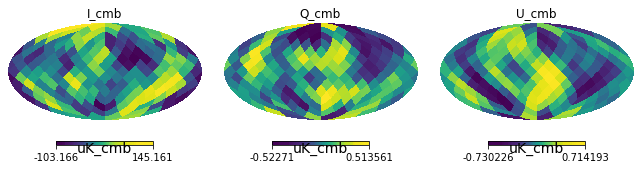

In [12]:
plt.figure(figsize=(15,6))
hp.mollview(c_maps_nest[0], norm='hist', sub=(1,5,1), title='I_cmb', unit="uK_cmb", nest=True)
hp.mollview(c_maps_nest[1], norm='hist', sub=(1,5,2), title='Q_cmb', unit="uK_cmb", nest=True)
hp.mollview(c_maps_nest[2], norm='hist', sub=(1,5,3), title='U_cmb', unit="uK_cmb", nest=True)

# Cal cov

In [13]:
def Read_dat(shape, bit, path):
    dt = np.dtype([("mat",bit)])
    fd = open(path, "r")
    chunk = np.fromfile(fd, dtype=dt, count=1)
    ar = chunk[0]["mat"].reshape(shape)
    return ar

In [14]:
(lmax+1)*8*(npix)**2

2654208

In [15]:
WXl = Read_dat((8,lmax+1,npix,npix), "<2654208d", '/home/tama/research/DeltaMap/CalculateXX_with_m_summed/Data/XX_m_summed_Nside4.dat')

In [16]:
QQ_E = WXl[0]
QU_E = WXl[1]
UQ_E = WXl[2]
UU_E = WXl[3]
QQ_B = WXl[4]
QU_B = WXl[5]
UQ_B = WXl[6]
UU_B = WXl[7]

In [17]:
QQ_E.shape

(9, 192, 192)

## spherical harmonics

In [18]:
wigner = spherical.Wigner(lmax)

In [19]:
def Cal_sYlm(nside):
    npix = 12*nside**2
    lmax = 2*nside
    Y_all = []
    Y__all = []
    W_all = []
    X_all = []
    for pix in range(npix):
        theta, phi = hp.pixelfunc.pix2ang(nside, pix, nest=True)
        R = quaternionic.array.from_spherical_coordinates(theta, phi)
        wigner = spherical.Wigner(lmax)
        Y = wigner.sYlm(2, R)
        Y_ = wigner.sYlm(-2, R)
        W = -1*(Y+Y_)/2
        X = -1j*(Y-Y_)/2
        #Y_all.append(Y)
        #Y__all.append(Y_)
        W_all.append(W)
        X_all.append(X)
    return np.array(W_all), np.array(X_all)

In [20]:
Wlm,Xlm = Cal_sYlm(nside)

## cov matrix

def Cal_matrix(WXl_E, WXl_B, clEE, clBB):
    lmax = 2*nside
    wl = hp.sphtfunc.pixwin(nside, pol=True, lmax=lmax)
    wl_P = wl[1]
    beam = hp.sphtfunc.gauss_beam(theta_pix, pol=True, lmax=lmax)
    beam_EE = beam[:,1]
    beam_BB = beam[:,2]
    matrix = np.zeros((npix,npix))
    for i in range(npix):
        i_nest = hp.pixelfunc.ring2nest(nside,i)
        for j in range(npix):
            j_nest = hp.pixelfunc.ring2nest(nside,j)
            matrix[i_nest,j_nest] = Cal_sum_l(WXl_E[i_nest,j_nest], clEE, wl_P, beam_EE) + Cal_sum_l(WXl_B[i_nest,j_nest], clBB, wl_P, beam_BB)
    return matrix

In [21]:
def Cal_matrix(F1lm, F2lm, G1lm, G2lm, clEE, clBB):
    npix = len(F1lm)
    nside = hp.pixelfunc.npix2nside(npix)
    lmax = 2*nside
    wl = hp.sphtfunc.pixwin(nside, pol=True, lmax=lmax)
    wl_P = wl[1]
    beam = hp.sphtfunc.gauss_beam(theta_pix, pol=True, lmax=lmax)
    beam_EE = beam[:,1]
    beam_BB = beam[:,2]
    matrix = np.zeros((npix,npix))*1.0j
    for i in range(npix):
        i_nest = hp.pixelfunc.ring2nest(nside,i)
        for j in range(npix):
            j_nest = hp.pixelfunc.ring2nest(nside,j)
            comp = Cal_sum_l(F1lm, F2lm, i, j, clEE, wl_P, beam_EE) + Cal_sum_l(G1lm, G2lm, i, j, clBB, wl_P, beam_BB)
            real = float(format(comp.real, '.13f'))
            imag = float(format(comp.imag, '.13f'))
            #print(real, imag)
            matrix[i_nest,j_nest] = complex(real, imag)
    return matrix

In [22]:
def Cal_sum_m(Flm, Glm, npix1, npix2, l):
    Wl = []
    for m in range(-l,l+1):
        f = Flm[npix1][wigner.Yindex(l,m)]*(Glm[npix2][wigner.Yindex(l,m)].conjugate())
        Wl.append(f)
    return sum(Wl)

In [23]:
def Cal_sum_l(Flm, Glm, npix1, npix2, cl, wl, beam_pol):
    mat_comp = []
    for l in range(2,lmax+1):
        fact = l*(l+1)/(2*np.pi)
        Wl = Cal_sum_m(Flm, Glm, npix1, npix2, l)
        f = wl[l]**2*beam_pol[l]**2*cl[l]/fact*Wl
        mat_comp.append(f)
    return sum(mat_comp)

def Cal_sum_l(Wl, cl, wl, beam_pol):
    mat_comp = []
    for l in range(2,lmax+1):
        fact = l*(l+1)/(2*np.pi)
        f = wl[l]**2*beam_pol[l]**2*cl[l]/fact*Wl[l]
        mat_comp.append(f)
    return sum(mat_comp)

In [24]:
def Cal_cov(Wlm, Xlm, clEE, clBB):
    C_QQ = Cal_matrix(Wlm, Wlm, Xlm, Xlm, clEE, clBB)
    C_QU = Cal_matrix(-Wlm, Xlm, Xlm, Wlm, clEE, clBB)
    C_UQ = Cal_matrix(-Xlm, Wlm, Wlm, Xlm, clEE, clBB)
    C_UU = Cal_matrix(Xlm, Xlm, Wlm, Wlm, clEE, clBB)
    
    C = np.zeros((2*npix,2*npix))
    C[0:npix, 0:npix] = C_QQ
    C[0:npix, npix:2*npix] = C_QU
    C[npix:2*npix, 0:npix] = C_UQ
    C[npix:2*npix, npix:2*npix] = C_UU
    return C

def Cal_cov(clEE, clBB):
    C_QQ = Cal_matrix(QQ_E, QQ_B, clEE, clBB)
    C_QU = Cal_matrix(QU_E, QU_B, clEE, clBB)
    C_UQ = Cal_matrix(UQ_E, UQ_B, clEE, clBB)
    C_UU = Cal_matrix(UU_E, UU_B, clEE, clBB)

    C = np.zeros((2*npix,2*npix))
    C[0:npix, 0:npix] = C_QQ
    C[0:npix, npix:2*npix] = C_QU
    C[npix:2*npix, 0:npix] = C_UQ
    C[npix:2*npix, npix:2*npix] = C_UU
    return C

In [25]:
def Cal_diag(amp):
    theta_pix = np.sqrt(4*np.pi/npix)
    diag = np.pi/10800*amp/theta_pix
    return diag

In [26]:
def Add_diag(C_,amp):
    for i in range(2*npix):
        diag = Cal_diag(amp)
        C_[i,i] = C_[i,i] + diag#**2
    return C_

In [27]:
amp = 0.2
diag = Cal_diag(amp)
diag**2

5.171345931835051e-08

In [28]:
Cs = []
for i,r in enumerate(rs):
    t = time.time()
    C = Cal_cov(Wlm, Xlm, c_cls[i][:,1], c_cls[i][:,2])
    C = Add_diag(C, amp)
    print(r,time.time()-t)
    Cs.append(C)

/tmp/ipykernel_2127619/2989455513.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  C[0:npix, 0:npix] = C_QQ
/tmp/ipykernel_2127619/2989455513.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  C[0:npix, npix:2*npix] = C_QU
/tmp/ipykernel_2127619/2989455513.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  C[npix:2*npix, 0:npix] = C_UQ
/tmp/ipykernel_2127619/2989455513.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  C[npix:2*npix, npix:2*npix] = C_UU


0.001 49.23850893974304
0.01 50.00109815597534
0.1 50.090306758880615
1.0 50.41794204711914


In [29]:
Cs[0]

array([[ 0.03613462, -0.00773502,  0.0005834 , ..., -0.00815524,
        -0.0057441 ,  0.        ],
       [-0.00773502,  0.03613462,  0.02321934, ..., -0.00420933,
        -0.00223246,  0.        ],
       [ 0.0005834 ,  0.02321934,  0.03613462, ..., -0.00535454,
        -0.00420933, -0.00475413],
       ...,
       [-0.00815524, -0.00420933, -0.00535454, ...,  0.03613462,
         0.02268273, -0.00462933],
       [-0.0057441 , -0.00223246, -0.00420933, ...,  0.02268273,
         0.03613462, -0.00504071],
       [ 0.        ,  0.        , -0.00475413, ..., -0.00462933,
        -0.00504071,  0.03613462]])

In [30]:
import Utils
help(Utils)

Help on module Utils:

NAME
    Utils

DESCRIPTION
    This module 'Utils' is auto-generated with f2py (version:1.20.3).
    Functions:
    Fortran 90/95 modules:
      utils --- dl,pi,twopi,fourpi,rad_to_arcmin,kelvin_to_ghz,invmatrix(),invcovmatrix().

DATA
    __f2py_numpy_version__ = '1.20.3'
    utils = <fortran object>

VERSION
    1.20.3

FILE
    /home/tama/research/delta_shadow/Utils.cpython-39-x86_64-linux-gnu.so




In [31]:
np.pi

3.141592653589793

In [32]:
float(Utils.utils.pi)

3.141592653589793

In [33]:
Utils.utils.pi

array(3.14159265)

In [34]:
Cs_inv = []
logdets = []
for i in range(len(rs)):
    C_inv,logdet = Utils.utils.invcovmatrix(Cs[i])
    Cs_inv.append(C_inv)
    logdets.append(logdet)

In [35]:
logdets

[-8672.20663996109, -8482.6944383416, -8068.78057589617, -7309.8423562211865]

### binary

In [11]:
C_s = Read_dat((2*npix,2*npix), "<147456d", '/home/tama/research/DeltaMap/Calculate_signal_cov_matrix/Data/Nside4/fwhm2220/scalar_Nside4.dat')
C_t = Read_dat((2*npix,2*npix), "<147456d", '/home/tama/research/DeltaMap/Calculate_signal_cov_matrix/Data/Nside4/fwhm2220/tensor_Nside4.dat')

In [12]:
def Cal_C_r(C_s, C_t, rs, amp, f):
    Cs = []
    for r in rs:
        C = C_s + r*C_t
        C = Add_diag(C, amp)
        Cs.append(C*f)
    return Cs

In [13]:
Cs_ = Cal_C_r(C_s, C_t, rs, amp, 1.)
Cs_[0]

array([[0.01313811, 0.01147137, 0.01147137, ..., 0.00334121, 0.00310424,
        0.002471  ],
       [0.01147137, 0.01313811, 0.00995081, ..., 0.00398394, 0.00329284,
        0.00309929],
       [0.01147137, 0.00995081, 0.01313811, ..., 0.0032263 , 0.00398394,
        0.0034994 ],
       ...,
       [0.00334121, 0.00398394, 0.0032263 , ..., 0.01313811, 0.00979584,
        0.01150878],
       [0.00310424, 0.00329284, 0.00398394, ..., 0.00979584, 0.01313811,
        0.01150878],
       [0.002471  , 0.00309929, 0.0034994 , ..., 0.01150878, 0.01150878,
        0.01313811]])

In [19]:
Cs_inv_ = []
logdets_ = []
for i in range(len(rs)):
    C_inv,logdet = Utils.utils.invcovmatrix(Cs_[i])
    Cs_inv_.append(C_inv)
    logdets_.append(logdet)

In [20]:
logdets_

[-9361.231783195451,
 -9298.653035602978,
 -9142.352498272227,
 -8852.090440987908]

# Cal x

In [37]:
def Read_map(path):
    hdul=fits.open(path)
    #print(hdul[1].header)
    d_data = hdul[1].data
    d_I = hp.pixelfunc.reorder(d_data.field(0), inp="NEST", out="NEST")
    d_Q = hp.pixelfunc.reorder(d_data.field(1), inp="NEST", out="NEST")
    d_U = hp.pixelfunc.reorder(d_data.field(2), inp="NEST", out="NEST")
    d_array = np.array([d_I, d_Q, d_U])
    return hdul, d_array

## dust map

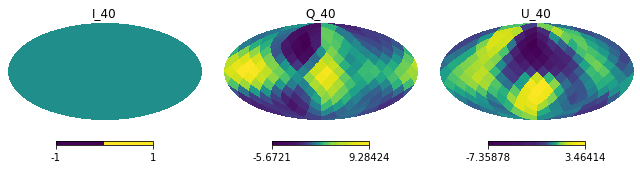

In [38]:
h_40, d_40 = Read_map("/home/tama/research/DeltaMap/SimulateForeground/Nside4/onecomp/foreground_40GHz_Nside4.fits")
plt.figure(figsize=(15,6))
hp.mollview(d_40[0], norm='hist', title='I_40', nest=True, sub=(1,5,1))
hp.mollview(d_40[1], norm='hist', title='Q_40', nest=True, sub=(1,5,2))
hp.mollview(d_40[2], norm='hist', title='U_40', nest=True, sub=(1,5,3))

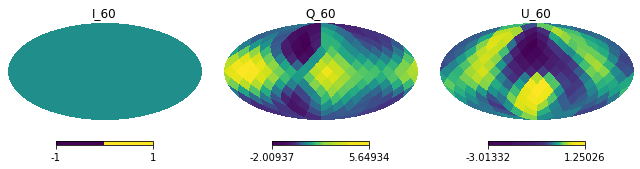

In [39]:
h_60, d_60 = Read_map("/home/tama/research/DeltaMap/SimulateForeground/Nside4/onecomp/foreground_60GHz_Nside4.fits")
plt.figure(figsize=(15,6))
hp.mollview(d_60[0], norm='hist', title='I_60', nest=True, sub=(1,5,1))
hp.mollview(d_60[1], norm='hist', title='Q_60', nest=True, sub=(1,5,2))
hp.mollview(d_60[2], norm='hist', title='U_60', nest=True, sub=(1,5,3))

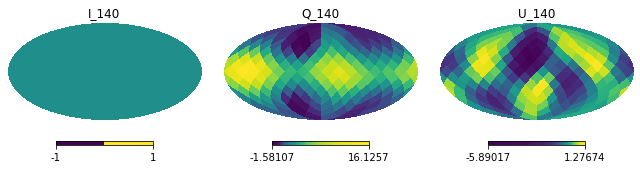

In [40]:
h_140, d_140 = Read_map("/home/tama/research/DeltaMap/SimulateForeground/Nside4/onecomp/foreground_140GHz_Nside4.fits")
plt.figure(figsize=(15,6))
hp.mollview(d_140[0], norm='hist', title='I_140', nest=True, sub=(1,5,1))
hp.mollview(d_140[1], norm='hist', title='Q_140', nest=True, sub=(1,5,2))
hp.mollview(d_140[2], norm='hist', title='U_140', nest=True, sub=(1,5,3))

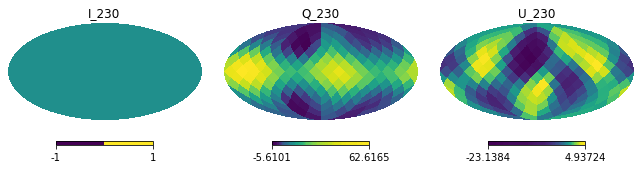

In [41]:
h_230, d_230 = Read_map("/home/tama/research/DeltaMap/SimulateForeground/Nside4/onecomp/foreground_230GHz_Nside4.fits")
plt.figure(figsize=(15,6))
hp.mollview(d_230[0], norm='hist', title='I_230', nest=True, sub=(1,5,1))
hp.mollview(d_230[1], norm='hist', title='Q_230', nest=True, sub=(1,5,2))
hp.mollview(d_230[2], norm='hist', title='U_230', nest=True, sub=(1,5,3))

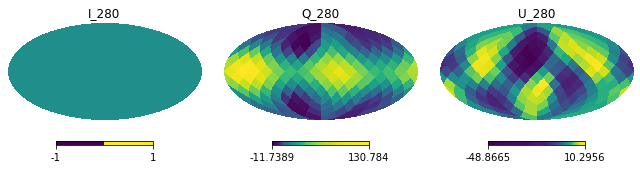

In [42]:
h_280, d_280 = Read_map("/home/tama/research/DeltaMap/SimulateForeground/Nside4/onecomp/foreground_280GHz_Nside4.fits")
plt.figure(figsize=(15,6))
hp.mollview(d_280[0], norm='hist', title='I_280', nest=True, sub=(1,5,1))
hp.mollview(d_280[1], norm='hist', title='Q_280', nest=True, sub=(1,5,2))
hp.mollview(d_280[2], norm='hist', title='U_280', nest=True, sub=(1,5,3))

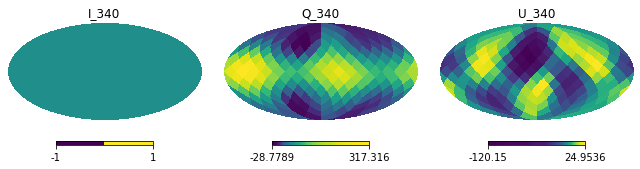

In [43]:
h_340, d_340 = Read_map("/home/tama/research/DeltaMap/SimulateForeground/Nside4/onecomp/foreground_340GHz_Nside4.fits")
plt.figure(figsize=(15,6))
hp.mollview(d_340[0], norm='hist', title='I_340', nest=True, sub=(1,5,1))
hp.mollview(d_340[1], norm='hist', title='Q_340', nest=True, sub=(1,5,2))
hp.mollview(d_340[2], norm='hist', title='U_340', nest=True, sub=(1,5,3))

In [60]:
d_maps = [d_40, d_60, d_140, d_230, d_280, d_340]

In [44]:
d_t_low.shape

NameError: name 'd_t_low' is not defined

In [ ]:
d_t_low= np.random.normal(loc=17,scale=0.1,size=d_t_low.shape)

In [ ]:
d_beta_low= np.random.normal(loc=1.5,scale=0.1,size=d_t_low.shape)

In [ ]:
plt.hist(d_t_low)

In [ ]:
plt.hist(d_beta_low)

In [ ]:
plt.figure(figsize=(15,6))
hp.mollview(d_t_low, norm="hist", sub=(1,5,2), title='Td')
hp.mollview(d_beta_low, norm="hist", sub=(1,5,3), title='beta')

## alpha

In [45]:
nus = np.array([40., 60., 140, 230., 280., 340.])

def Cal_d(nu, nu_ref, beta_ave, Td_ave):
    xc = nu/(T_c*Utils.utils.kelvin_to_ghz)
    xc_ref = nu_ref/(T_c*Utils.utils.kelvin_to_ghz)
    g = (nu_ref/nu)**4 * np.exp(xc_ref)/np.exp(xc) * (np.exp(xc)-1)**2/(np.exp(xc_ref)-1)**2
    xd = nu/(Td_ave*Utils.utils.kelvin_to_ghz)
    xd_ref = nu_ref/(Td_ave*Utils.utils.kelvin_to_ghz)
    d = g*(nu/nu_ref)**(beta_ave+3) * (np.exp(xd_ref)-1)/(np.exp(xd)-1)
    d_ = d * np.array([1, (xd*np.exp(xd)/(np.exp(xd)-1) - (xd_ref*np.exp(xd_ref))/(np.exp(xd_ref)-1))/Td_ave, np.log(nu/nu_ref)])
    return g, d_

def Cal_d_Kcmb(nu, nu_ref, beta_ave, Td_ave):
    xc = nu/(T_c*Utils.utils.kelvin_to_ghz)
    #xc_ref = nu_ref/(T_c*Utils.utils.kelvin_to_ghz)
    g = (nu_ref/nu)**4 /np.exp(xc) * (np.exp(xc)-1)**2
    xd = nu/(Td_ave*Utils.utils.kelvin_to_ghz)
    #xd_ref = nu_ref/(Td_ave*Utils.utils.kelvin_to_ghz)
    d = g*(nu/nu_ref)**(beta_ave+3) /(np.exp(xd)-1)
    d_ = d * np.array([1, (xd*np.exp(xd)/(np.exp(xd)-1)), np.log(nu/nu_ref)])
    return g, d_

In [85]:
1/(np.exp(1/(Utils.utils.kelvin_to_ghz*T_c))-1)

56.28123535134685

In [86]:
1/(np.exp(1/(Td_ave*Utils.utils.kelvin_to_ghz))-1)

398.5213286444103

In [47]:
def Cal_d(nu, betas, beta_ave, Td_ave):
    xc = nu/56.780
    g = (np.exp(xc)-1.)**2 / (xc**2 * np.exp(xc)) * 1000.0
    xd = nu/(Td_ave*Utils.utils.kelvin_to_ghz)
    #xd_ref = nu_ref/(Td_ave*Utils.utils.kelvin_to_ghz)
    dd = g * nu**beta_ave / (np.exp(xd)-1.)
    ds = g * nu**betas
    D = np.array([ds, ds*np.log(nu), dd, dd*(xd*np.exp(xd)/(np.exp(xd)-1.)), dd*np.log(nu)])
    return g, D

In [48]:
def Cal_alpha(nus, betas, beta_ave, Td_ave):
    gs = []
    ds = []
    nuc = nus[0]
    g, dc = Cal_d(nuc, betas, beta_ave, Td_ave)
    gs.append(g)
    ds.append(dc)
    A = np.zeros((len(nus[1:]), 5))
    for i in range(len(nus)-1):
        g, d = Cal_d(nus[i+1], betas, beta_ave, Td_ave)
        A[:,i] = d
        gs.append(g)
        ds.append(d)
    A_inv = Utils.utils.invmatrix(A)
    alpha = -np.matmul(A_inv, dc)
    return gs, ds, A, alpha

In [49]:
betas = -2.9
beta_ave = 2.85
Td_ave = 19.15
gs, ds, A, alpha = Cal_alpha(nus, betas, beta_ave, Td_ave)

In [50]:
alpha

array([ -4.972065  ,  22.76789247, -29.43548724,  17.07547065,
        -2.32277035])

In [51]:
ds

[array([2.35457970e-02, 8.68576069e-02, 3.63700932e+08, 3.82235112e+08,
        1.34164889e+09]),
 array([7.64547137e-03, 3.13031941e-02, 7.89873462e+08, 8.50747028e+08,
        3.23401411e+09]),
 array([9.68437023e-04, 4.78566948e-03, 5.04384968e+09, 5.98032514e+09,
        2.49249015e+10]),
 array([4.78492888e-04, 2.60208227e-03, 2.33301178e+10, 3.06963834e+10,
        1.26871031e+11]),
 array([4.49435594e-04, 2.53247501e-03, 5.20491821e+10, 7.24295436e+10,
        2.93286190e+11]),
 array([5.04113292e-04, 2.93844896e-03, 1.34884244e+11, 2.00414651e+11,
        7.86232922e+11])]

In [52]:
A

array([[7.64547137e-03, 9.68437023e-04, 4.78492888e-04, 4.49435594e-04,
        5.04113292e-04],
       [3.13031941e-02, 4.78566948e-03, 2.60208227e-03, 2.53247501e-03,
        2.93844896e-03],
       [7.89873462e+08, 5.04384968e+09, 2.33301178e+10, 5.20491821e+10,
        1.34884244e+11],
       [8.50747028e+08, 5.98032514e+09, 3.06963834e+10, 7.24295436e+10,
        2.00414651e+11],
       [3.23401411e+09, 2.49249015e+10, 1.26871031e+11, 2.93286190e+11,
        7.86232922e+11]])

## noise map

In [53]:
noise = diag*np.random.normal(loc=0.,scale=1,size=12*nside**2)
noise_nest = hp.pixelfunc.reorder(noise, inp='RING', out='NEST')
#noise_nest = hp.pixelfunc.ud_grade(noise_nest, nside_out=nside)

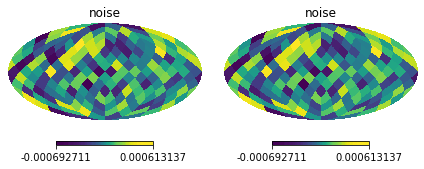

In [54]:
plt.figure(figsize=(15,6))
hp.mollview(noise, norm="hist", sub=(1,5,2), title='noise')
hp.mollview(noise_nest, norm="hist", sub=(1,5,3), nest=True, title='noise')

In [55]:
noise_cl = hp.anafast(noise)

(2.0, 8.0)

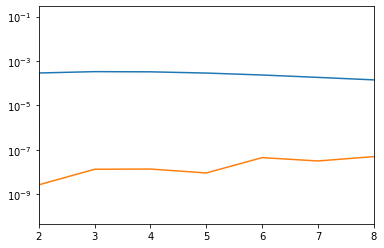

In [56]:
l = np.arange(len(c_cls[0][:,0]))
plt.plot(l,c_cls[1][:,2], label='0.001')
l = np.arange(len(noise_cl))
plt.plot(l,noise_cl*l*(l+1)/(2*np.pi))
plt.yscale("log")
plt.xlim(2,25)
plt.xlim(2,8)

## map

def Cal_D(nu, beta, Td):
    xd = nu/(Td*Utils.utils.kelvin_to_ghz)
    xd_ref = nu_ref/(Td*Utils.utils.kelvin_to_ghz)
    D = (nu/nu_ref)**(beta+3) * (np.exp(xd_ref)-1)/(np.exp(xd)-1)
    return D

def Make_map_(g, nu, c_map, fg_ref, beta, Td):
    maps = np.zeros(2*npix)
    f = g*Cal_D(nu, beta, Td)*fg_ref
    maps[:npix] = c_map[1] + f[1]
    maps[npix:2*npix] = c_map[2] + f[2]
    return maps

In [69]:
def Make_map(g, nu, c_map, fg):
    c_nest_Q = hp.pixelfunc.reorder(c_map[1], inp='RING', out='NEST')
    c_nest_U = hp.pixelfunc.reorder(c_map[2], inp='RING', out='NEST')
    maps = np.zeros(2*npix)
    maps[:npix] = c_nest_Q + fg[1]
    maps[npix:2*npix] = c_nest_U + fg[2]
    return maps

In [70]:
def App_smooth(maps, rad):
    maps_sm = np.zeros(2*npix)
    maps_sm[:npix] = hp.sphtfunc.smoothing(maps[:npix], fwhm=rad)
    maps_sm[npix:2*npix] = hp.sphtfunc.smoothing(maps[npix:2*npix], fwhm=rad)
    return maps_sm

In [75]:
maps = Make_map(gs[0],nus[0], c_maps[i_r], d_maps[5])
maps_sm = App_smooth(maps, rad)
#maps_sm_nest = np.zeros(2*npix)
#maps_sm_nest[:npix] = hp.pixelfunc.reorder(maps_sm[:npix], inp='RING', out='NEST')
#maps_sm_nest[npix:2*npix] = hp.pixelfunc.reorder(maps_sm[npix:2*npix], inp='RING', out='NEST')

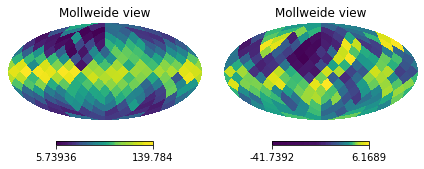

In [77]:
plt.figure(figsize=(15,6))
hp.mollview(maps_sm[:npix], norm="hist", sub=(1,5,2), nest=True)#, title='Td')
hp.mollview(maps_sm[npix:2*npix], norm="hist", sub=(1,5,3), nest=True)#, title='beta')

def Make_map(g, nu, c_map, fg_ref, beta, Td, rad):
    maps_nest = np.zeros(2*npix)
    f = g*Cal_D(nu, beta, Td)*fg_ref
    #plt.figure(figsize=(15,6))
    #hp.mollview(f[1], norm="hist", sub=(1,5,2))#, nest=True)#, title='Td')
    #hp.mollview(f[2], norm="hist", sub=(1,5,3))#, nest=True)#, title='beta')
    #beam = hp.sphtfunc.gauss_beam(theta_pix, pol=True, lmax=lmax)
    maps_Q = c_map[1] + f[1]
    maps_U = c_map[2] + f[2]
    maps_Q_sm = hp.sphtfunc.smoothing(maps_Q, fwhm=rad)
    maps_U_sm = hp.sphtfunc.smoothing(maps_U, fwhm=rad)
    #plt.figure(figsize=(15,6))
    #hp.mollview(maps_Q, norm="hist", sub=(1,5,2))#, nest=True)#, title='Td')
    #hp.mollview(maps_U, norm="hist", sub=(1,5,3))#, nest=True)#, title='beta')
    maps_nest[:npix] = hp.pixelfunc.reorder(maps_Q_sm, inp='RING', out='NEST')
    maps_nest[npix:2*npix] = hp.pixelfunc.reorder(maps_Q_sm, inp='RING', out='NEST')
    return maps_nest

In [64]:
2200/60*np.pi/180

0.6399540590645875

In [65]:
rad

0.6395791924665553

In [66]:
2.5*np.sqrt(4*np.pi/npix*(180/np.pi)**2)*60 #minutes

2198.7113035631396

maps = Make_map(gs[0],nus[0], c_maps[i_r], d_map, d_beta_low, d_t_low, rad)

plt.figure(figsize=(15,6))
hp.mollview(maps_sm_nest[:npix], norm="hist", sub=(1,5,2), nest=True)#, title='Td')
hp.mollview(maps_sm_nest[npix:2*npix], norm="hist", sub=(1,5,3), nest=True)#, title='beta')

In [68]:
def Add_noise(maps_nest, amp):
    diag = Cal_diag(amp)
    noise_Q = diag*np.random.normal(loc=0.,scale=1,size=12*nside**2)
    noise_U = diag*np.random.normal(loc=0.,scale=1,size=12*nside**2)
    noise_Q_nest = hp.pixelfunc.reorder(noise_Q, inp='RING', out='NEST')
    noise_U_nest = hp.pixelfunc.reorder(noise_U, inp='RING', out='NEST')
    #plt.figure(figsize=(15,6))
    #hp.mollview(noise_Q, norm="hist", sub=(1,5,2), title='noise')
    #hp.mollview(noise_U, norm="hist", sub=(1,5,3), title='noise')
    maps_n = np.zeros(2*npix)
    maps_n[:npix] = maps_nest[:npix] + noise_Q_nest
    maps_n[npix:2*npix] = maps_nest[npix:2*npix] + noise_U_nest
    return maps_n

maps = np.zeros(2*npix)
maps[:npix]=hp.pixelfunc.reorder(c_maps[i_r][1], inp='RING', out='NEST')
maps[npix:2*npix]=hp.pixelfunc.reorder(c_maps[i_r][2], inp='RING', out='NEST')
maps_n = Add_noise(maps, amp)

In [ ]:
maps_n = Add_noise(maps_sm_nest, amp)

In [ ]:
plt.figure(figsize=(15,6))
hp.mollview(maps_n[:npix], norm="hist", sub=(1,5,2), nest=True)#, title='Td')
hp.mollview(maps_n[npix:2*npix], norm="hist", sub=(1,5,3), nest=True)#, title='beta')

## x

def Cal_maps(gs, nus, c_map, fg_ref, beta, Td, rad, amp):
    maps_j = []
    maps_c = Make_map(gs[0], nus[0], c_map, fg_ref, beta, Td, rad)
    maps_c_n = Add_noise(maps_c, amp)
    maps_j.append(maps_c_n)
    for i in range(len(nus)-1):
        maps = Make_map(gs[i+1], nus[i+1], c_map, fg_ref, beta, Td, rad)
        maps_n = Add_noise(maps, amp)
        maps_j.append(maps_n)
    return maps_j

In [ ]:
def Cal_maps(gs, nus, c_map, fg_ref, beta, Td, rad, amp):
    maps_j = []
    maps_c = Make_map(gs[0], nus[0], c_map, d_maps[0])
    maps_c_sm = App_smooth(maps_c, rad)
    maps_c_sm_nest = np.zeros(2*npix)
    maps_c_sm_nest[:npix] = hp.pixelfunc.reorder(maps_c_sm[:npix], inp='RING', out='NEST')
    maps_c_sm_nest[npix:2*npix] = hp.pixelfunc.reorder(maps_c_sm[npix:2*npix], inp='RING', out='NEST')
    maps_c_n = Add_noise(maps_c_sm_nest, amp)
    maps_j.append(maps_c_n)
    for i in range(len(nus)-1):
        maps = Make_map(gs[i+1], nus[i+1], c_map, d_maps[i+1])
        maps_sm = App_smooth(maps, rad)
        maps_sm_nest = np.zeros(2*npix)
        maps_sm_nest[:npix] = hp.pixelfunc.reorder(maps_sm[:npix], inp='RING', out='NEST')
        maps_sm_nest[npix:2*npix] = hp.pixelfunc.reorder(maps_sm[npix:2*npix], inp='RING', out='NEST')
        maps_n = Add_noise(maps_sm_nest, amp)
        maps_j.append(maps_n)
    return maps_j

In [ ]:
maps_j = Cal_maps(gs, nus, c_maps[i_r], d_map, d_beta_low, d_t_low, rad, amp)

In [ ]:
def Cal_x(maps_j, alpha):
    a_maps = []
    for i in range(len(nus)-1):
        a_maps.append(alpha[i]*maps_j[i+1])
    x = (maps_j[0] + np.sum(a_maps, axis=0))/(1+sum(alpha))
    return x

In [ ]:
x = Cal_x(maps_j, alpha)

# Estimation

## likelihood

In [ ]:
def Cal_lnL(x, C_inv, logdet):
    cov = scipy.linalg.blas.dgemm(alpha=1., a=C_inv, b=x).reshape((2*npix,))
    #cov = np.matmul(C_inv, x)
    lnL = (np.dot(x.T,cov) + logdet)/2
    #print((np.dot(x.T,cov)), logdet)
    return lnL

In [ ]:
def Cal_lnChisq(x, C_inv):
    cov = scipy.linalg.blas.dgemm(alpha=1., a=C_inv, b=x).reshape((2*npix,))
    lnL = np.dot(x.T,cov)
    return lnL

def Cal_lnL(x, C_inv, logdet):
    cov = np.matmul(C_inv, x)
    lnL = (np.dot(x.T,cov) + logdet)/2
    #print((np.dot(x.T,cov)), logdet)
    return lnL

def Cal_lnChisq(x, C_inv):
    cov = np.matmul(C_inv, x)
    lnL = np.dot(x.T,cov)
    return lnL

## test

def C_max(rs, x, Wlm, Xlm, c_cls, diag):
    Cs = []
    lnLs = []
    for i,r in enumerate(rs):
        t = time.time()
        C = Cal_cov(Wlm, Xlm, c_cls[i][:,1], c_cls[i][:,2])
        C = Add_diag(C, diag)
        lnL = Cal_lnL(x, C)
        print(r,lnL,time.time()-t)
        Cs.append(C)
        lnLs.append(lnL)
    r_max = rs[np.argmax(lnLs)]
    return r_max, Cs, lnLs

In [ ]:
def C_max_(rs, Cs_inv, logdets, x):
    lnLs = []
    for i,r in enumerate(rs):
        lnL = Cal_lnL(x, Cs_inv[i], logdets[i])
        lnLs.append(lnL)
    r_min = rs[np.argmin(lnLs)]
    return r_min, lnLs

def C_max_(rs, Cs_inv, logdets, x):
    lnLs = []
    for i,r in enumerate(rs):
        lnL = test.Utils_likelihood(Cs_inv[i], x) + logdets[i]
        lnLs.append(lnL)
    r_min = rs[np.argmin(lnLs)]
    return r_min, lnLs

In [ ]:
rs[i_r]

In [ ]:
r_min, lnLs_r = C_max_(rs, Cs_inv, logdets_, x)
lnLs_r

In [ ]:
r_min

In [ ]:
plt.scatter(rs, lnLs_r)
#plt.yscale("log")
plt.ylabel("lnL")
plt.xlabel("r")
plt.xscale("log")

In [204]:
def x_beta_min(betas, Td_ave, C_inv, nus, nu_ref, rad, amp):
    xs = []
    lnChisqs = []
    for i,beta_ave in enumerate(betas):
        gs, ds, A, alpha = Cal_alpha(nus, betas, beta_ave, Td_ave)
        maps_j = Cal_maps(gs, nus, c_maps[i_r], d_map, d_beta_low, d_t_low, rad, amp)
        x = Cal_x(maps_j, alpha)
        lnChisq = Cal_lnChisq(x, C_inv)
        xs.append(x)
        lnChisqs.append(lnChisq)
    beta_min = betas[np.argmin(lnChisqs)]
    return beta_min, xs, lnChisqs

In [205]:
betas = np.linspace(2,3,100)
beta_min, xs_b, lnChisqs_b = x_beta_min(betas, Td_ave, Cs_inv[i_r], nus, nu_ref, rad, amp)
beta_min

TypeError: Cal_alpha() missing 1 required positional argument: 'Td_ave'

Text(0.5, 0, 'beta')

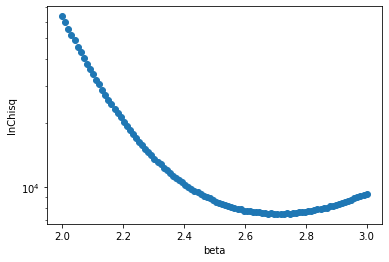

In [162]:
plt.scatter(betas, lnChisqs_b)
plt.yscale('log')
plt.ylabel("lnChisq")
plt.xlabel("beta")

In [156]:
def x_Td_min(Tds, beta_ave, C_inv, nus, nu_ref, rad, amp):
    xs = []
    lnChisqs = []
    for i,Td_ave in enumerate(Tds):
        gs, ds, A, alpha = Cal_alpha(nus, betas, beta_ave, Td_ave)
        maps_j = Cal_maps(gs, nus, c_maps[i_r], d_map, d_beta_low, d_t_low, rad, amp)
        x = Cal_x(maps_j, alpha)
        lnChisq = Cal_lnChisq(x, C_inv)
        xs.append(x)
        lnChisqs.append(lnChisq)
    Td_min = Tds[np.argmin(lnChisqs)]
    return Td_min, xs, lnChisqs

In [157]:
Tds = np.linspace(5,25,100)
Td_min, xs_T, lnChisqs_T = x_Td_min(Tds, beta_ave, Cs_inv[i_r], nus, nu_ref, rad, amp)
Td_min

14.696969696969697

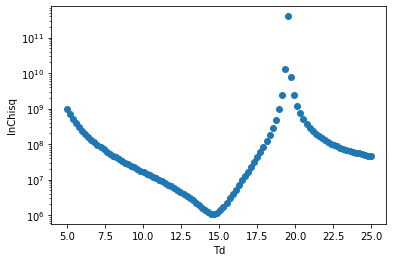

In [158]:
plt.scatter(Tds, lnChisqs_T)
plt.ylabel("lnChisq")
plt.xlabel("Td")
plt.yscale("log")

## Gibbs sampling

In [78]:
def gibbs_sampling_(ir_pri,beta_pri,Td_pri, rs,betas,Tds, niter, nus,nu_ref, Cs,logdets, rad, amp):
    r_sample = [rs[ir_pri]]
    beta_sample = [beta_pri]
    Td_sample = [Td_pri]
    C_min = Cs[ir_pri]
    for k in range(niter):
        print(r_sample[k], beta_sample[k], Td_sample[k])
        #beta
        lnChisqs = []
        for i,beta in enumerate(betas):
            gs, ds, A, alpha = Cal_alpha(nus, nu_ref, beta, Td_sample[k])
            maps_j = Cal_maps(gs, nus, c_maps[i_r], d_map, d_beta_low, d_t_low, rad, amp)
            x = Cal_x(maps_j, alpha)
            lnChisq = Cal_lnChisq(x, C_min)
            lnChisqs.append(lnChisq)
        beta_min = betas[np.argmin(lnChisqs)]
        beta_sample.append(beta_min)
        
        #Td
        xs = []
        lnChisqs = []
        for i,Td in enumerate(Tds):
            gs, ds, A, alpha = Cal_alpha(nus, nu_ref, beta_min, Td)
            maps_j = Cal_maps(gs, nus, c_maps[i_r], d_map, d_beta_low, d_t_low, rad, amp)
            x = Cal_x(maps_j, alpha)
            lnChisq = Cal_lnChisq(x, C_min)
            xs.append(x)
            lnChisqs.append(lnChisq)
        Td_min = Tds[np.argmin(lnChisqs)]
        x_min = xs[np.argmin(lnChisqs)]
        Td_sample.append(Td_min)
        
        #r
        lnLs = []
        for i,r in enumerate(rs):
            lnL = Cal_lnL(x_min, Cs[i], logdets[i])
            lnLs.append(lnL)
        r_min = rs[np.argmin(lnLs)]
        C_min = Cs[np.argmin(lnLs)]
        r_sample.append(r_min)
    return r_sample, beta_sample, Td_sample

In [79]:
#i_r = 4
rs[i_r]

0.01

In [80]:
#own
niter = 100
betas = np.linspace(1.,2.,100)
Tds = np.linspace(10.,30,100)
r_sample, beta_sample, Td_sample = gibbs_sampling_(i_r,beta_ave,Td_ave, rs,betas,Tds, niter, nus,nu_ref, Cs_inv,logdets, rad, amp)

0.01 1.598081 19.395966
0.1 1.8888888888888888 23.13131313131313
0.1 1.9191919191919191 24.141414141414142
0.1 1.676767676767677 23.13131313131313
0.1 1.9595959595959598 20.707070707070706
0.1 2.0 27.77777777777778
0.1 1.9696969696969697 25.757575757575758
0.1 1.9292929292929295 29.7979797979798
0.1 1.7676767676767677 18.686868686868685
0.1 1.9191919191919191 10.202020202020202
0.1 1.97979797979798 22.727272727272727
0.1 2.0 14.848484848484848
0.1 2.0 20.505050505050505
0.1 1.8585858585858586 22.727272727272727
0.1 1.8888888888888888 28.78787878787879
0.1 1.98989898989899 21.717171717171716
0.1 1.7373737373737375 21.515151515151516
0.1 1.7777777777777777 24.545454545454547


KeyboardInterrupt: 

In [633]:
#binary
niter = 100
betas = np.linspace(1.,2.,100)
Tds = np.linspace(10.,30,100)
r_sample, beta_sample, Td_sample = gibbs_sampling_(i_r,beta_ave,Td_ave, rs,betas,Tds, niter, nus,nu_ref, Cs_inv_,logdets_, rad, amp)

0.01 1.598081 19.395966
1.0 1.5454545454545454 20.707070707070706
1.0 1.7171717171717171 25.555555555555557
1.0 1.7777777777777777 25.95959595959596
1.0 1.696969696969697 29.19191919191919
1.0 1.606060606060606 25.15151515151515
1.0 1.6363636363636365 15.858585858585858
1.0 1.7070707070707072 23.939393939393938
1.0 1.7070707070707072 27.373737373737374
1.0 1.7070707070707072 29.595959595959595
1.0 1.696969696969697 29.19191919191919
1.0 1.676767676767677 19.8989898989899
1.0 1.6363636363636365 25.757575757575758
1.0 1.6868686868686869 21.515151515151516
1.0 1.7272727272727273 22.525252525252526
1.0 1.7171717171717171 30.0
1.0 1.6363636363636365 20.1010101010101
1.0 1.6464646464646466 26.363636363636363
1.0 1.6161616161616164 22.323232323232325
1.0 1.6868686868686869 11.818181818181818
1.0 1.7171717171717171 29.7979797979798
1.0 1.6565656565656566 14.444444444444445
1.0 1.6161616161616164 27.575757575757574
1.0 1.5858585858585859 27.77777777777778
1.0 1.6262626262626263 28.7878787878787

In [128]:
r_est = np.mean(r_sample[1:])
beta_est = np.mean(beta_sample[1:])
Td_est = np.mean(Td_sample[1:])
print(r_est, beta_est, Td_est)

0.127 1.6723232323232322 20.682828282828282


Text(0.5, 1.0, 'Td')

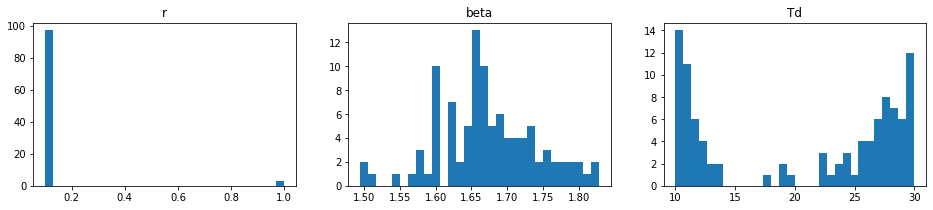

In [129]:
bins = 30
fig = plt.figure(figsize=(16,3))
ax1 = fig.add_subplot(1,3,1)
ax1.hist(r_sample[1:], bins=bins)
ax1.set_title('r')
ax2 = fig.add_subplot(1,3,2)
ax2.hist(beta_sample[1:], bins=bins)
ax2.set_title('beta')
ax3 = fig.add_subplot(1,3,3)
ax3.hist(Td_sample[1:], bins=bins)
ax3.set_title('Td')
#ax3.xlim(10,29)

Text(0.5, 1.0, 'Td')

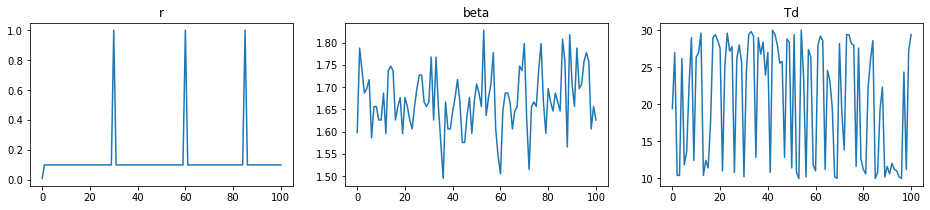

In [130]:
#bins = 10
i = np.arange(0,101)
fig = plt.figure(figsize=(16,3))
ax1 = fig.add_subplot(1,3,1)
ax1.plot(i,r_sample[0:])#, bins=bins)
ax1.set_title('r')
ax2 = fig.add_subplot(1,3,2)
ax2.plot(i,beta_sample[0:])#, bins=bins)
ax2.set_title('beta')
ax3 = fig.add_subplot(1,3,3)
ax3.plot(i,Td_sample[0:])#, bins=bins)
ax3.set_title('Td')
#ax3.xlim(10,29)